Seja o conjunto de imagens satelitais associadas às regiões urbanas (pasta [Questão 2](../data/q2]))

As imagens RGB img46.png, img47.png, img66.png e img67.png apresentam um silo, conforme indicado abaixo. Implemente um código responsável pela seleção dos conjuntos de pixels associados ao objeto silo.

In [1]:
import cv2
import pandas as pd
from utils import *
import numpy as np

## Visualizando objeto de detecção

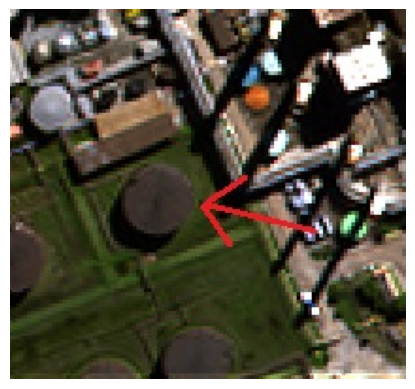

In [2]:
#leitura da imagem com openCV
image = cv2.imread('../assets/case_fig1.png')
# visualização usando matplotlib
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')  
plt.show()

## Visualizando imagens disponibilziadas

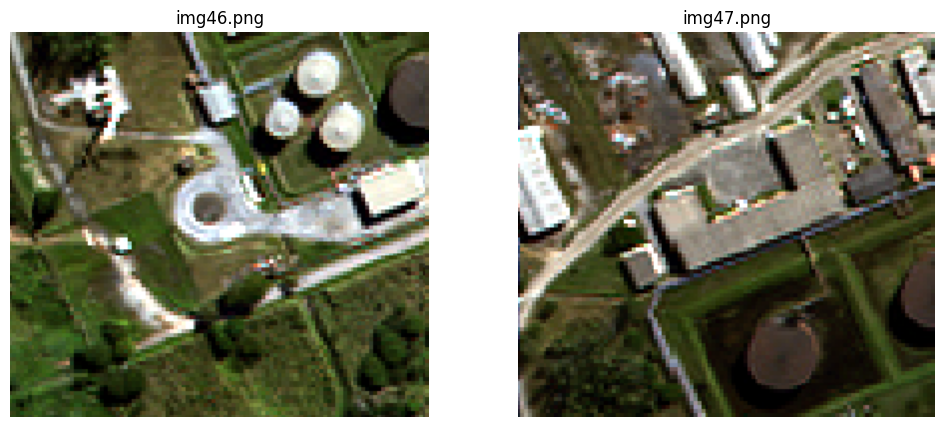

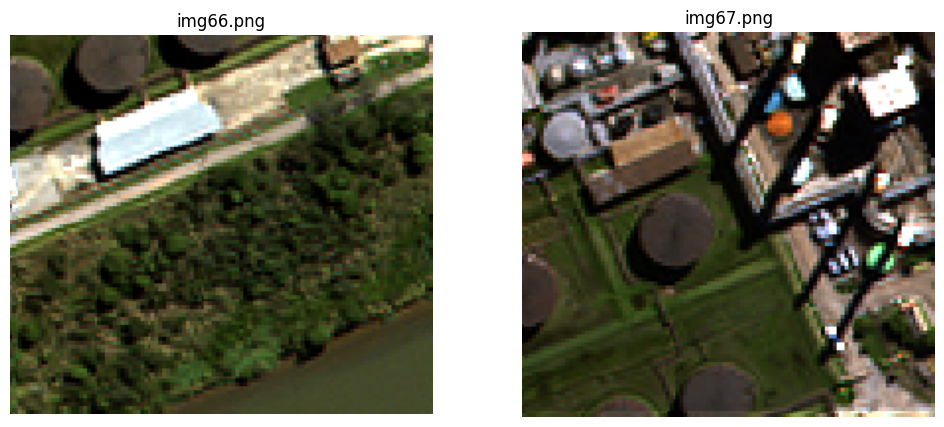

In [3]:
#listando e plotando as imagens
png_paths = list_files('../data/q2',['.png'])
png_imgs = [cv2.imread(path) for path in png_paths]

#plotando aos pares
num_imgs = len(png_imgs)
for i in range(0, num_imgs, 2):
    if i + 1 < num_imgs:    
        img_n_title = [(cv2.cvtColor(png_imgs[i],cv2.COLOR_BGR2RGB),os.path.basename(png_paths[i])),
                        (cv2.cvtColor(png_imgs[i+1], cv2.COLOR_BGR2RGB),os.path.basename(png_paths[i+1]))]            
        plot_side_by_side(img_n_title)

## Foram coletadas amostras de pixel de silo nos espaços de cores RGB e HSL visando identificar um _treshold_

In [4]:
silo_samples = pd.read_csv('../data/q2/silo_samples.csv')
silo_samples.head()

,red,green,blue,hue,saturation,luminance
0,68,63,56,23,23,58
1,57,47,38,19,48,45
2,71,52,46,10,51,55
3,77,66,52,22,47,61
4,75,69,58,26,31,63


## Determinando um treshold

In [5]:
silo_samples.describe()

,red,green,blue,hue,saturation,luminance
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.00000
mean,66.000000,56.800000,49.400000,30.600000,30.800000,54.40000
std,7.731609,8.482662,7.136759,20.451569,17.067187,6.25744
min,55.000000,47.000000,38.000000,4.000000,3.000000,45.00000
25%,59.000000,50.500000,46.000000,19.750000,21.250000,49.00000
50%,67.000000,53.000000,49.000000,24.500000,27.000000,54.00000
75%,71.000000,65.250000,55.000000,48.000000,47.750000,60.25000
max,77.000000,69.000000,59.000000,62.000000,51.000000,63.00000


### Teste com HSL e Green
Referência (~ min-(2*std) -> max+(2*std)):
- H: 0 -> 104
- S: 0 -> 85
- L: 0 -> 75
- G: 0 -> 70

In [74]:
lower_h, upper_h = 0,104 
lower_s,upper_s = 0, 85
lower_l,upper_l = 35, 75
lower_g,upper_g = 0, 80

# Cria  kernel do tipo cruz
cross_kernel_3 = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
cross_kernel_5 = cv2.getStructuringElement(cv2.MORPH_CROSS, (5, 5))


def hue_tresh(img):
    hsl_image = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
    #aplica treshold
    return cv2.inRange(hsl_image, np.array([lower_h, lower_l, lower_s]), np.array([upper_h, upper_l, upper_s]))

def green_tresh(img):
    return cv2.inRange(img, np.array([0, lower_g, 0]), np.array([255, upper_g, 255]))

def apply_morph(result_mask):
    mask_morph = cv2.erode(result_mask,cross_kernel_3,iterations=3)   
    return cv2.dilate(mask_morph,cross_kernel_5,iterations=3)
def getBlobs(result_mask):
    # Apply the connected components labeling
    num_labels, labeled_image, stats, centroids = cv2.connectedComponentsWithStats(result_mask, connectivity=4)

    # Initialize a list to store blob information
    blobs = []

    # Loop through the labeled components
    for label in range(1, num_labels):  # Skip background label (label 0)
        area = stats[label, cv2.CC_STAT_AREA]  # Area in pixels
        x, y = int(centroids[label, 0]), int(centroids[label, 1])  # Centroid coordinates
        rect = stats[label, [cv2.CC_STAT_LEFT, cv2.CC_STAT_TOP, cv2.CC_STAT_WIDTH, cv2.CC_STAT_HEIGHT]]  # Bounding box

        # Create a binary mask for the current blob
        blob_mask = (labeled_image == label).astype(np.uint8)

        blobs.append({
            'label': label,
            'area': area,
            'centroid': (x, y),
            'bounding_box': rect,
            'mask': blob_mask
        })

    return blobs






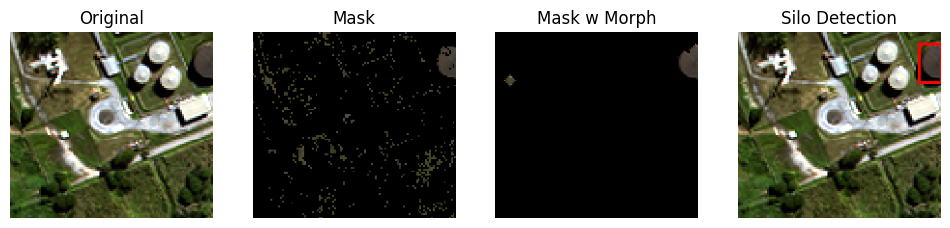

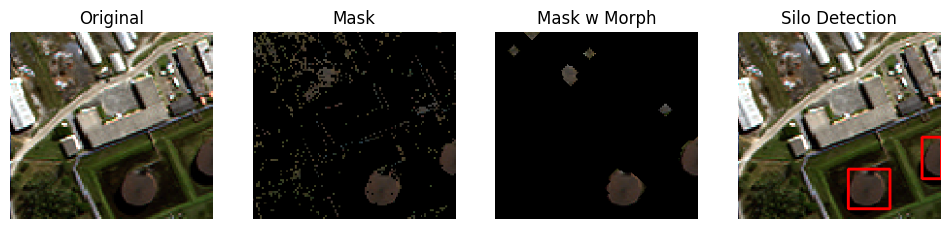

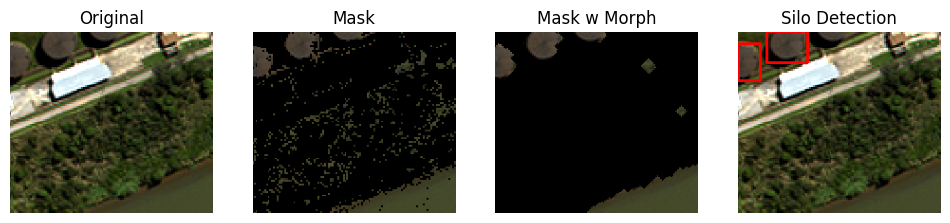

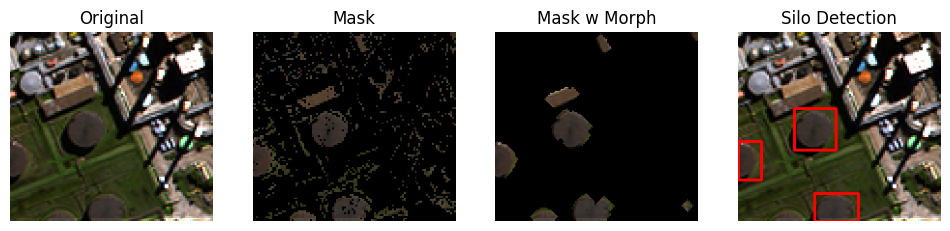

In [83]:

for img in png_imgs:
    _img = np.copy(img)    
    hue_mask = hue_tresh(img)
    #coverte para hsl    
    green_mask = green_tresh(img)
    #combinando mascaras
    result_mask = cv2.bitwise_and(hue_mask, green_mask)    
    #aplicação de operadores morfológicos para suavisar a mascara
    mask_morph = apply_morph(result_mask)
   
    
    #aplica mascara na imagem original
    thresh_1 = cv2.bitwise_and(img, img, mask=result_mask)
    thresh_2 = cv2.bitwise_and(img, img, mask=mask_morph)

    blobs = getBlobs(mask_morph)
    
    for blob in blobs:
        #filtro pela area dos blobs
        if blob['area']> 500 and blob['area']< 1500:
            x, y, width, height  = blob['bounding_box']
            cv2.rectangle(_img, (x, y), (x + width, y + height), (0, 0, 255), 2)  # Draw the bounding box             
   
    plot_side_by_side([(cv2.cvtColor(img,cv2.COLOR_BGR2RGB),'Original'),
                      (cv2.cvtColor(thresh_1,cv2.COLOR_BGR2RGB),'Mask'),
                      (cv2.cvtColor(thresh_2,cv2.COLOR_BGR2RGB),'Mask w Morph'),                      
                      (cv2.cvtColor(_img,cv2.COLOR_BGR2RGB),'Silo Detection')
                      ])